In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings
from sklearn import linear_model
import statsmodels.api as sm

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [4]:
df = df.drop(['dailysummary'], axis=1)

In [5]:
# Treat null values using interpolation.
df = df.interpolate(method='bfill', limit=2)

In [6]:
# dataframe.size 
size = df.size 
  
# dataframe.shape 
shape = df.shape 
  
# dataframe.ndim 
df_ndim = df.ndim 
  
# series.ndim 
series_ndim = df["temperature"].ndim 
  
# printing size and shape 
print("Size = {}\nShape ={}\nShape[0] x Shape[1] = {}". 
format(size, shape, shape[0]*shape[1])) 
  
# printing ndim 
print("ndim of dataframe = {}\nndim of series ={}". 
format(df_ndim, series_ndim)) 

Size = 1060983
Shape =(96453, 11)
Shape[0] x Shape[1] = 1060983
ndim of dataframe = 2
ndim of series =1


## Investigate the data, and do any necessary data cleaning.

In [7]:
#df.info()
df.describe(include='all')

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453,96453,96453,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
unique,96429,27,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2010-08-02 19:00:00+00:00,Partly Cloudy,rain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,31733,85224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2005-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2016-12-31 22:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,NaN,NaN,NaN,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,NaN,NaN,NaN,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,NaN,NaN,NaN,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000


In [8]:
non_numeric_columns = df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['summary', 'preciptype'], dtype='object')
The number of non-numerical columns is 2


In [9]:
numeric_columns = df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['temperature', 'apparenttemperature', 'humidity', 'windspeed',
       'windbearing', 'visibility', 'loudcover', 'pressure'],
      dtype='object')
The number of numerical columns is 8


In [10]:
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
pressure,0,0.0
loudcover,0,0.0
visibility,0,0.0
windbearing,0,0.0
windspeed,0,0.0
humidity,0,0.0
apparenttemperature,0,0.0
temperature,0,0.0
preciptype,0,0.0
summary,0,0.0


## Explore the data and find some variables that you think would be useful in predicting house prices.

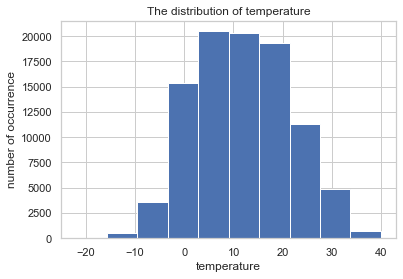

In [11]:
plt.hist(df.temperature)
plt.title("The distribution of temperature")
plt.xlabel("temperature")
plt.ylabel("number of occurrence")
plt.show()

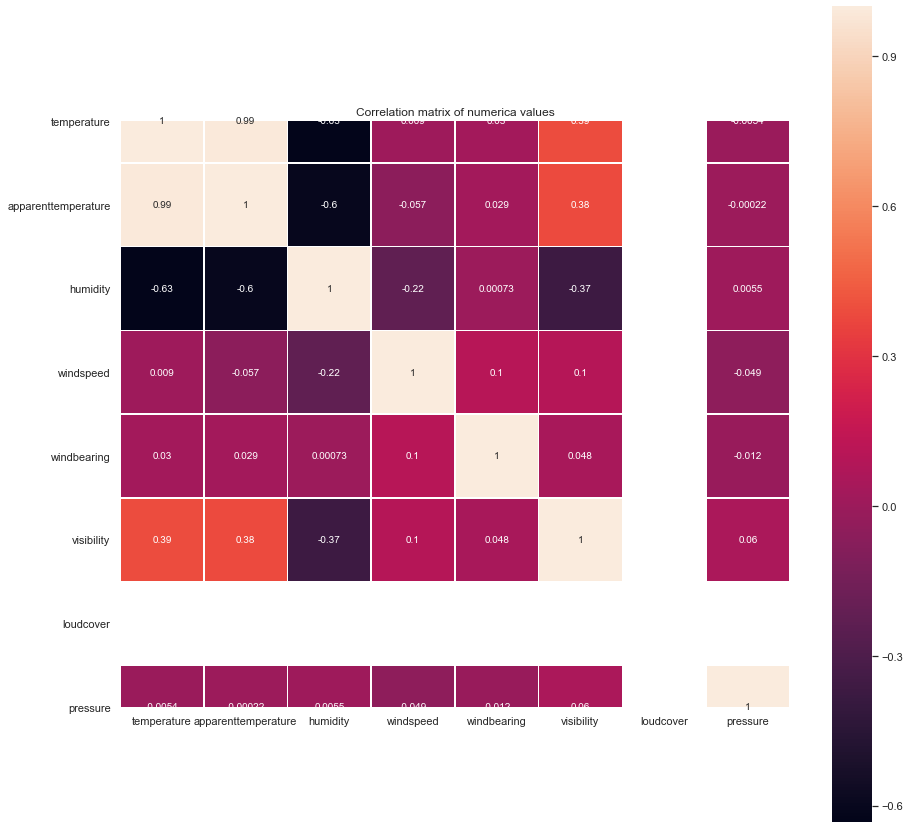

In [12]:
cormat = df[numeric_columns].corr()
plt.figure(figsize=(15,15))
sns.heatmap(cormat, square=True, annot=True, linewidths=.5)
plt.title("Correlation matrix of numerica values")
plt.show()

In [13]:
np.abs(df[numeric_columns].iloc[:,0:].corr().loc[:,"temperature"]).sort_values(ascending=False)

temperature            1.000000
apparenttemperature    0.992629
humidity               0.632255
visibility             0.392847
windbearing            0.029988
windspeed              0.008957
pressure               0.005447
loudcover                   NaN
Name: temperature, dtype: float64

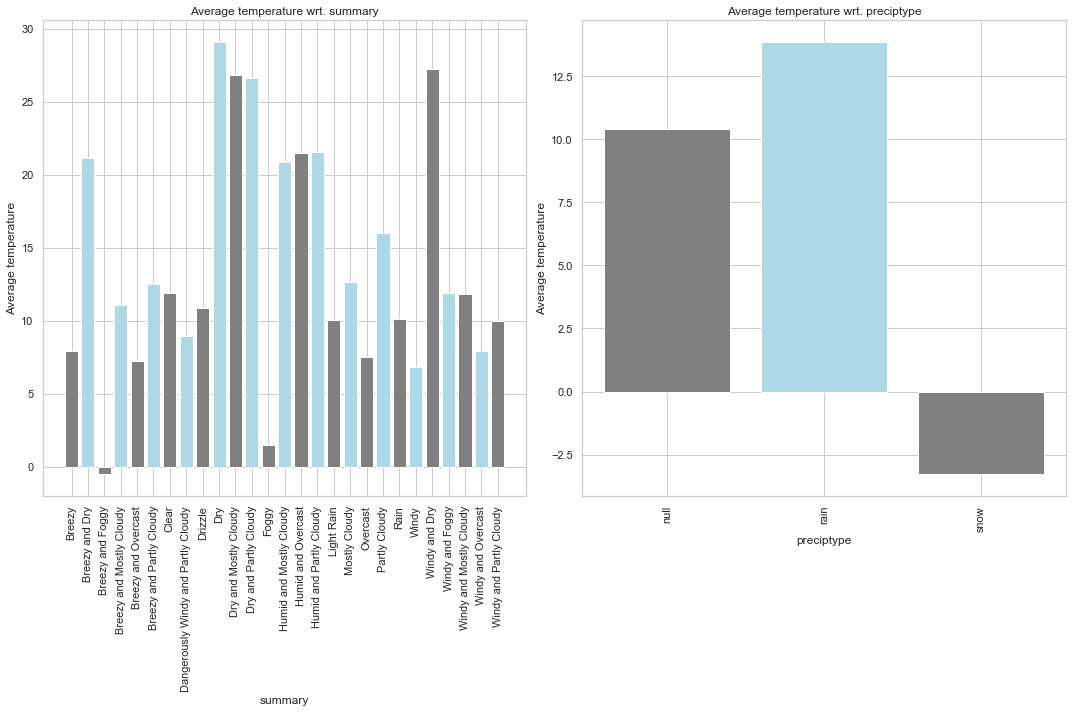

In [14]:
plt.figure(figsize=(15,10))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(1,2,index+1)
    plt.bar(df.groupby(column)["temperature"].mean().index, df.groupby(column)["temperature"].mean(),
           color=("grey","lightblue"))
    plt.title("Average temperature wrt. {}".format(column))
    plt.ylabel("Average temperature")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [15]:
df['rain'] = np.where(df['preciptype'] == 'rain', 1, 0)
df['snow'] = np.where(df['preciptype'] == 'snow', 1, 0)

In [16]:
df = pd.concat([df,pd.get_dummies(df.preciptype, prefix="preciptype", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df.summary, prefix="summary", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(df.preciptype, prefix="preciptype", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.summary, prefix="summary", drop_first=True).columns)

## Build your initial model using these features and estimate the parameters using OLS.

In [17]:
X = df[['humidity', 'visibility', 'windbearing']]
X2 = df[['humidity', 'visibility', 'windbearing']]
Y = df.temperature

In [18]:
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-2.75869148e+01  4.17850334e-01  1.92790942e-03]

Intercept: 
 27.52113958400043


In [19]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                 2.422e+04
Date:                Fri, 16 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:14:31   Log-Likelihood:            -3.2745e+05
No. Observations:               96453   AIC:                         6.549e+05
Df Residuals:                   96449   BIC:                         6.549e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          27.5211      0.137    201.150      0.000      27.253      27.789
humidity      -27.5869      0.128   -215.721      0.000     -27.838     -27.336
visibility      0.4179      0.006     69.995      0.000       0.406       0.430
windbearing     0.0019      0.000      8.901      0.000       0.002       0.002
==============================================================================
Omnibus:                     2632.824   Durbin-Watson:                   0.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2852.534
Skew:                          -0.416   Prob(JB):                         0.00
Kurtosis:                       3.126   Cond. No.                     1.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Assumptions of linear regression

### Check for all of the Gauss Markov Assumptions and discuss the implications if some of the assumptions are not met:

    linearity of models in their coefficients
    the error term should be zero on average
    homoscedasticity
    low multicollinearity
    error terms should be uncorrelated with one another
    features shouldn't be correlated with the errors
    normality of the errors

### Assumption one: linearity of the model in its coefficients

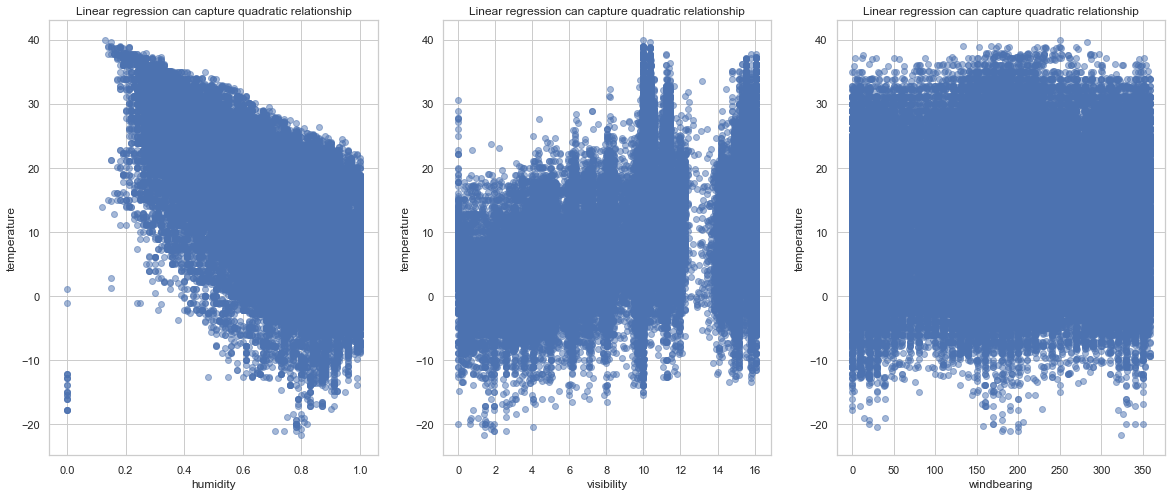

In [20]:
# we plot the estimated Y and X
# the relationship should be quadratic

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.scatter(df.humidity, df.temperature, alpha=0.5)
plt.xlabel("humidity")
plt.ylabel("temperature")
plt.title('Linear regression can capture quadratic relationship')


plt.subplot(1,3,2)
plt.scatter(df.visibility, df.temperature, alpha=0.5)
plt.xlabel("visibility")
plt.ylabel("temperature")
plt.title('Linear regression can capture quadratic relationship')

plt.subplot(1,3,3)
plt.scatter(df.windbearing, df.temperature, alpha=0.5)
plt.xlabel("windbearing")
plt.ylabel("temperature")
plt.title('Linear regression can capture quadratic relationship')


plt.show()


### Assumpiton two: the error term should be zero on average

In [21]:
predictions = lrm.predict(X2)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -4.139510166384825e-15


### Assumption three: homoscedasticity

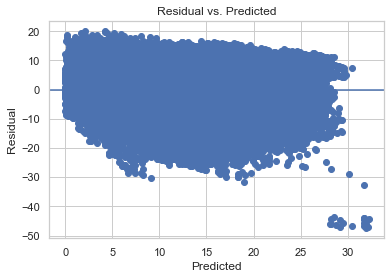

In [22]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [23]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 1928.82 and p value is 0
Levene test statistic value is 1510.02 and p value is 0


### Assumption four: low multicollinearity

### Assumption five: error terms should be uncorrelated with one another

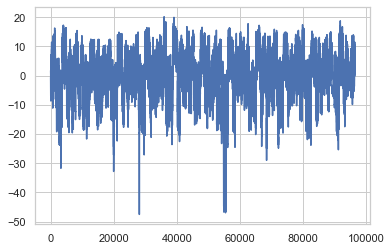

In [24]:
plt.plot(errors)
plt.show()

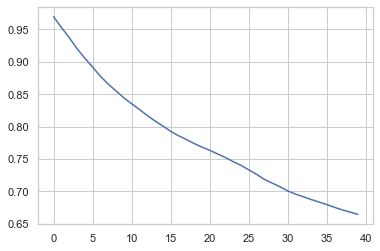

In [25]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

### Assumption six: normality of the errors

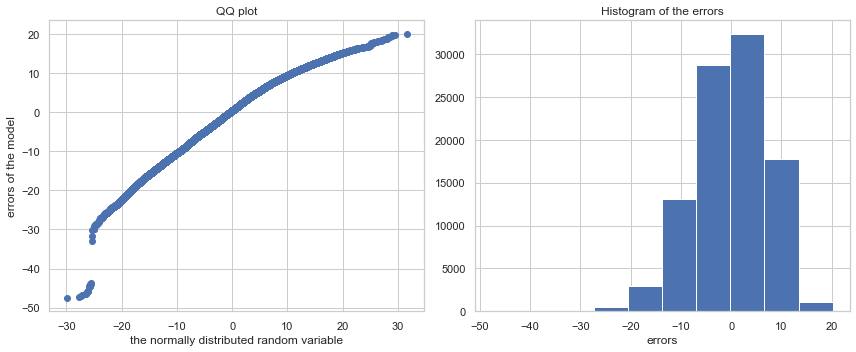

In [26]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [27]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 2852.5340893776915 and p value is 0.0
Normality test statistics is 2632.8240789214387 and p value is 0.0


# Interpreting estimated coefficients

### Build a linear regression model where your target variable is the difference between the apparenttemperature and the temperature. As explanatory variables, use humidity and windspeed. Now, estimate your model using OLS. Are the estimated coefficients statistically significant? Are the signs of the estimated coefficients in line with your previous expectations? Interpret the estimated coefficients. What are the relations between the target and the explanatory variables?

In [28]:
df["temp_difference"] = df.temperature - df.apparenttemperature

X4 = df[['humidity', 'windspeed']]
Y4 = df.temp_difference

In [29]:
X4 = sm.add_constant(X4)

results = sm.OLS(Y4, X4).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        temp_difference   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.949e+04
Date:                Fri, 16 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:14:38   Log-Likelihood:            -1.7046e+05
No. Observations:               96453   AIC:                         3.409e+05
Df Residuals:                   96450   BIC:                         3.409e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4381      0.021   -115.948      0.0

### Next, include the interaction of humidity and windspeed to the model above and estimate the model using OLS. Are the coefficients statistically significant? Did the signs of the estimated coefficients for humidity and windspeed change? Interpret the estimated coefficients.

In [30]:
# Y is the target variable
Y5 = df['temperature']

# This is the interaction between bmi and smoking
df["humid_wind"] = df.humidity * df.windspeed

# X is the feature set
X5 = df[['humidity','windspeed', 'humid_wind']]

# We add a constant to the model as it's a best practice
# to do so every time!
X5 = sm.add_constant(X5)

# We fit an OLS model using statsmodels
results2 = sm.OLS(Y4, X5).fit()

# We print the summary results
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:        temp_difference   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                 1.666e+04
Date:                Fri, 16 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:14:38   Log-Likelihood:            -1.6669e+05
No. Observations:               96453   AIC:                         3.334e+05
Df Residuals:                   96449   BIC:                         3.334e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0839      0.033     -2.511      0.0

In [31]:
#costs_bmi = df.humidity * 3.02
#costs_bmi_smokers = df.humidity * (-0.1775)
#costs_bmi_non_smokers = df.humidity * 0.2971


#plt.plot(df.humidity, costs_bmi)
#plt.plot(df.humidity, costs_bmi_smokers)
#plt.plot(df.humidity, costs_bmi_non_smokers)
#plt.legend(["costs and bmi", "costs and bmi (smokers)", "costs and bmi (non-smokers)"])
#plt.xlabel("humidity")
#plt.ylabel("costs")
#plt.title("The relationship between bmi, smoking and costs")

#plt.show()

# Evaluating performance

### Like in the previous checkpoint, build a linear regression model where your target variable is the difference between the apparenttemperature and the temperature. As explanatory variables, use humidity and windspeed. Now, estimate your model using OLS. What are the R-squared and adjusted R-squared values? Do you think they are satisfactory? Why?

    They are both 0.288. I don't think that thay are satisfactory due to how far from 21 they sit.

### Next, include the interaction of humidity and windspeed to the model above and estimate the model using OLS. Now, what is the R-squared of this model? Does this model improve upon the previous one?

    It is 0.341. That is an improvement!

### Add visibility as an additional explanatory variable to the first model and estimate it. Did R-squared increase? What about adjusted R-squared? Compare the differences put on the table by the interaction term and the visibility in terms of the improvement in the adjusted R-squared. Which one is more useful?

In [36]:
X6 = df[['humidity', 'windspeed', 'visibility']]
Y6 = df.temp_difference

In [37]:
X6 = sm.add_constant(X6)

results = sm.OLS(Y6, X6).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        temp_difference   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                 1.401e+04
Date:                Fri, 16 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:15:14   Log-Likelihood:            -1.6938e+05
No. Observations:               96453   AIC:                         3.388e+05
Df Residuals:                   96449   BIC:                         3.388e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5756      0.028    -56.605      0.0

There was a slight increase of R2 and Adj R2 to 0.304.

Compared to the interation model, there was a slight descrease of R2 and Adj R2. 0.304 vs. 0.341

### Choose the best one from the three models above with respect to their AIC and BIC scores. Validate your choice by discussing your justification with your mentor.

With regard to the AIC and BIC scores, the second model, or the interaction model performed the best.